In [31]:
## ALL IMPORTS FOR A NEW NOTEBOOK

import os, sys, random, math
import numpy as np
import pandas as pd
import matplotlib.pylab as plt
import seaborn as sns
import itertools as it
import scipy
import glob
import matplotlib
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import Dataset,DataLoader
from torch.optim import Optimizer
import torchvision.transforms.transforms as txf
import torch.optim.lr_scheduler as lr_scheduler
from collections import OrderedDict

from sklearn import metrics
from sklearn import preprocessing as pp
from sklearn import model_selection as ms

import torch_utils
from tqdm.notebook import tqdm_notebook as tqdm
import time


font = {'size'   : 20}
matplotlib.rc('font', **font)

In [32]:
from torchtext import data
from torchtext import datasets

In [93]:
def generate_ngrams(tokens, n=3):
    total_tokens = len(tokens)
    for i in range(total_tokens-n+1):
        tokens.append(" ".join(tokens[i:i+n]))
    return tokens

In [94]:
generate_ngrams("This film is terrible".split())

['This', 'film', 'is', 'terrible', 'This film is', 'film is terrible']

In [95]:
SEED = 1234
torch_utils.seed_everything(SEED)

In [96]:
TEXT = data.Field(tokenize="spacy", preprocessing=generate_ngrams)
LABEL = data.LabelField(dtype=torch.float)

In [106]:
%%time
train_data, test_data = datasets.IMDB.splits(TEXT, LABEL)

CPU times: user 1min 9s, sys: 898 ms, total: 1min 10s
Wall time: 1min 10s


In [107]:
train_data, valid_data = train_data.split(random_state=random.seed(SEED), split_ratio=0.8)

In [108]:
%%time
MAX_VOCAB_SIZE = 25000
TEXT.build_vocab(
    train_data,
    max_size=MAX_VOCAB_SIZE,
    vectors="glove.6B.100d",
    unk_init=torch.Tensor.normal_
)
LABEL.build_vocab(train_data)

CPU times: user 8.48 s, sys: 199 ms, total: 8.68 s
Wall time: 8.67 s


In [109]:
BATCH_SIZE = 128
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

train_iterator, valid_iterator, test_iterator = data.BucketIterator.splits(
    (train_data, valid_data, test_data),
    batch_sizes=(BATCH_SIZE, BATCH_SIZE, BATCH_SIZE),
    device = device
)

In [110]:
class FastText(nn.Module):
    def __init__(self, vocab_size, embedding_dim, output_dim, pad_idx):
        super(FastText, self).__init__()
        self.embedding = nn.Embedding(vocab_size, embedding_dim, padding_idx=pad_idx)
        self.fc = nn.Linear(embedding_dim, output_dim)
    
    def forward(self, txt):
        embed = self.embedding(txt)
        embed = embed.permute(1, 0, 2)
        pooled = F.avg_pool2d(embed, (embed.shape[1], 1)).squeeze(1)
        return self.fc(pooled)

In [111]:
def binary_accuracy(preds, y):
    rounded_preds = torch.round(torch.sigmoid(preds))
    correct = (rounded_preds==y).float()
    return correct.sum()/len(correct)

In [112]:
def train(model, iterator, optimizer, criterion):
    tl,ta = 0,0
    model.train()
    
    for txt, lbl in tqdm(iterator):
        optimizer.zero_grad()
        preds = model(txt).squeeze(1)
        loss = criterion(preds, lbl)
        acc = binary_accuracy(preds, lbl)
        loss.backward()
        optimizer.step()
        tl+=loss.item()
        ta+=acc.item()
    
    return tl/len(iterator), ta/len(iterator)

In [113]:
def evaluate(model, iterator, criterion):
    l,a = 0,0
    model.eval()
    with torch.no_grad():
        for txt, lbl in tqdm(iterator):
            preds = model(txt).squeeze(1)
            loss = criterion(preds, lbl)
            acc = binary_accuracy(preds, lbl)
            l+=loss.item()
            a+=acc.item()
    
    return l/len(iterator), a/len(iterator)

In [114]:
INPUT_DIM = len(TEXT.vocab)
EMBEDDING_DIM = 100
OUTPUT_DIM = 1
PAD_IDX = TEXT.vocab.stoi[TEXT.pad_token]
UNK_IDX = TEXT.vocab.stoi[TEXT.unk_token]

model = FastText(INPUT_DIM, EMBEDDING_DIM, OUTPUT_DIM, PAD_IDX).to(device)
pretrained_embedding = TEXT.vocab.vectors
model.embedding.weight.data.copy_(pretrained_embedding)
model.embedding.weight.data[UNK_IDX] = torch.zeros(EMBEDDING_DIM)
model.embedding.weight.data[PAD_IDX] = torch.zeros(EMBEDDING_DIM)

In [115]:
N_EPOCHS = 15
best_valid_loss = float("inf")
history = pd.DataFrame()
optimizer = torch_utils.RAdam(model.parameters(), lr=0.005)
criterion = nn.BCEWithLogitsLoss().to(device)


for e in range(N_EPOCHS):
    t = time.time()
    tl, ta = train(model, train_iterator, optimizer, criterion)
    vl, va = evaluate(model, valid_iterator, criterion)
    
    if vl<best_valid_loss:
        best_valid_loss = vl
        torch.save(model.state_dict(),"tut3-model.pt")
    history.loc[e, "train_loss"] = tl
    history.loc[e, "train_acc"] = ta
    history.loc[e, "valid_loss"] = vl
    history.loc[e, "valid_acc"] = va
    history.loc[e, "epoch_time"] = time.time()-t
    print("EPOCH: {} TIME: {}".format(e+1, time.time()-t))
    print("TRAIN LOSS: {:.5f} TRAIN ACC: {:.5f}%".format(tl, 100.0*ta))
    print("VALID LOSS: {:.5f} VALID ACC: {:.5f}%".format(vl, 100.0*va))
    
    torch_utils.clear_cuda()


EPOCH: 1 TIME: 11.668461084365845
TRAIN LOSS: 0.69145 TRAIN ACC: 53.72213%
VALID LOSS: 0.67338 VALID ACC: 68.41797%



EPOCH: 2 TIME: 10.665176153182983
TRAIN LOSS: 0.67526 TRAIN ACC: 63.71915%
VALID LOSS: 0.56545 VALID ACC: 74.08203%



EPOCH: 3 TIME: 10.740931272506714
TRAIN LOSS: 0.60603 TRAIN ACC: 75.78623%
VALID LOSS: 0.48239 VALID ACC: 78.84766%



EPOCH: 4 TIME: 10.487881660461426
TRAIN LOSS: 0.50210 TRAIN ACC: 81.66799%
VALID LOSS: 0.44473 VALID ACC: 83.86719%



EPOCH: 5 TIME: 11.106849670410156
TRAIN LOSS: 0.40604 TRAIN ACC: 86.30573%
VALID LOSS: 0.42811 VALID ACC: 86.60156%



EPOCH: 6 TIME: 10.58323049545288
TRAIN LOSS: 0.33732 TRAIN ACC: 89.18690%
VALID LOSS: 0.44929 VALID ACC: 88.10547%



EPOCH: 7 TIME: 10.6671724319458
TRAIN LOSS: 0.28716 TRAIN ACC: 90.82902%
VALID LOSS: 0.48260 VALID ACC: 88.45703%



EPOCH: 8 TIME: 10.49431300163269
TRAIN LOSS: 0.24848 TRAIN ACC: 92.09295%
VALID LOSS: 0.51724 VALID ACC: 89.29688%



EPOCH: 9 TIME: 10.497605800628662
TRAIN LOSS: 0.21759 TRAIN ACC: 93.10311%
VALID LOSS: 0.54828 VALID ACC: 89.88281%



EPOCH: 10 TIME: 10.694903135299683
TRAIN LOSS: 0.19475 TRAIN ACC: 93.94904%
VALID LOSS: 0.57357 VALID ACC: 89.94141%



EPOCH: 11 TIME: 10.56890320777893
TRAIN LOSS: 0.16932 TRAIN ACC: 94.82982%
VALID LOSS: 0.59965 VALID ACC: 90.05859%



EPOCH: 12 TIME: 10.297789335250854
TRAIN LOSS: 0.15306 TRAIN ACC: 95.39212%
VALID LOSS: 0.63426 VALID ACC: 90.23438%



EPOCH: 13 TIME: 10.495731592178345
TRAIN LOSS: 0.13349 TRAIN ACC: 96.31270%
VALID LOSS: 0.66937 VALID ACC: 90.39062%



EPOCH: 14 TIME: 10.5395827293396
TRAIN LOSS: 0.12194 TRAIN ACC: 96.78045%
VALID LOSS: 0.70605 VALID ACC: 90.31250%



EPOCH: 15 TIME: 10.454496383666992
TRAIN LOSS: 0.10863 TRAIN ACC: 97.12381%
VALID LOSS: 0.74471 VALID ACC: 90.23438%


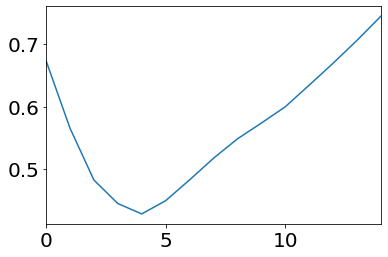

In [116]:
history["valid_loss"].plot()

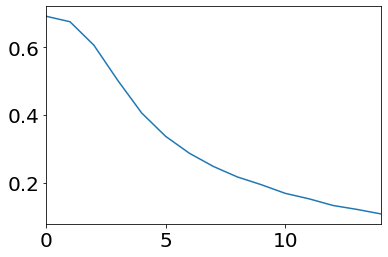

In [117]:
history["train_loss"].plot()

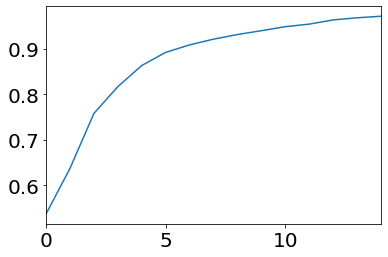

In [118]:
history["train_acc"].plot()

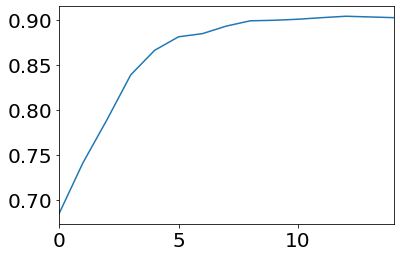

In [119]:
history["valid_acc"].plot()

In [120]:
testl, testa = evaluate(model, test_iterator, criterion)
print(testl, testa*100.0)


0.7927544049310441 89.67235331632652


In [121]:
model.load_state_dict(torch.load("tut3-model.pt", map_location=device))

<All keys matched successfully>

In [122]:
testl, testa = evaluate(model, test_iterator, criterion)
print(testl, testa*100.0)


0.4398747519875059 86.13042092444945


In [123]:
import spacy
nlp = spacy.load("en")

In [135]:
def predict_sentiment(model, txt):
    model.eval()
    
    tokenized = generate_ngrams([tok.text for tok in nlp.tokenizer(txt)])
    indexed = [TEXT.vocab.stoi[t] for t in tokenized]
    tensor = torch.LongTensor(indexed).to(device)
    tensor = tensor.unsqueeze(dim=1)
    pred = torch.sigmoid(model(tensor))
    
    return pred.item()

In [142]:
predict_sentiment(model, "This film is awesomely boring")

9.106033704853189e-10